<a href="https://colab.research.google.com/github/racoonjonny/Tensorflow_study/blob/main/7_RNN_Ex_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# RNN을 이용한 삼성 전자 주가 예측 모델 생성.

# 1. 데이터 로드 및 분포 확인

# 2. 데이터 전처리
 
# 3. 데이터 생성

# 4. 순환신경망 모델 구축 및 학습

In [2]:
# 1-1 데이터 로드
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

raw_df = pd.read_csv('./005930.KS.csv')

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


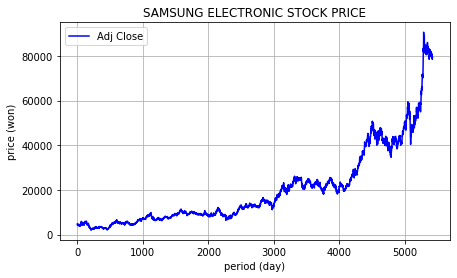

In [3]:
# 1-2.데이터 분포 확인
plt.figure(figsize = (7,4))
plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price (won)')
plt.xlabel('period (day)')
plt.grid()

plt.plot(raw_df['Adj Close'], label = 'Adj Close', color = 'b')
plt.legend(loc = 'best')

plt.show()

In [4]:
# 2. 데이터 전처리

# 2-1 outlier 확인.
# 통계쩍으로 비정상적으로 크거나 작은 데이터인 outlier는 딥러닝 학습을 하기 위해서 적절한 값으로 바꾸거나 삭제하는 등의 처리가 반드시 필요함.

raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5414.000000,5414.000000,5414.000000,5414.000000,5414.000000,5.414000e+03,5418.000000,5416.000000
mean,23066.858146,23309.303657,22823.529738,23066.603251,20198.046134,2.203700e+07,20212.176960,20204.083077
std,18117.963534,18285.327998,17955.779317,18114.251221,17758.196440,1.561772e+07,17749.315590,17730.952088
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9920.000000,10020.000000,9820.000000,9920.000000,7752.151367,1.183885e+07,7740.515950,7732.563330
50%,15850.000000,16000.000000,15680.000000,15890.000000,12909.491700,1.799813e+07,12917.547525,12902.487405
75%,29435.000000,29740.000000,29175.000000,29430.000000,24673.033200,2.766808e+07,24689.639320,24705.820705
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [5]:
# 2-2 missing value 확인
raw_df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [6]:
raw_df.loc[raw_df['Open'].isna()]
# 주식과 같은 금융데이터에서 NaN으로 표시되는 missing value는 평균값이나 중간값 등으로 대체하지 않고 해당되는 행 전체를 삭제하는 것이 일반적임.

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [7]:
# Volume 값 0을 NaN으로 모두 대체 (replace)
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 개수 확인

for col in raw_df.columns:
  missing_rows = raw_df.loc[raw_df[col] == 0].shape[0]
  print(col + ':' + str(missing_rows))

Date:0
Open:0
High:0
Low:0
Close:0
Adj Close:0
Volume:0
3MA:0
5MA:0


In [9]:
raw_df = raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [11]:
# 2-3 정규화 (normalization)
# 날짜를 제외하고 숫자로 표현되는 모든 column을 0~1 값으로 정규화 수행함.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 정규화 대상 column 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

print(type(scaled_df))

# 정규화된 새로운 dataframe 생성
scaled_df = pd.DataFrame(scaled_df, columns = scale_cols)

3print(scaled_df)

<class 'numpy.ndarray'>
          Open      High       Low  ...       3MA       5MA    Volume
0     0.034868  0.032008  0.036288  ...  0.025192  0.025698  0.285359
1     0.037375  0.035517  0.038470  ...  0.025634  0.025094  0.363715
2     0.034982  0.031689  0.036518  ...  0.026163  0.025343  0.177799
3     0.034868  0.031689  0.036059  ...  0.025987  0.025503  0.250704
4     0.036235  0.033177  0.037437  ...  0.026163  0.026018  0.300555
...        ...       ...       ...  ...       ...       ...       ...
5289  0.872379  0.812846  0.877124  ...  0.883539  0.887577  0.079956
5290  0.865542  0.810719  0.872531  ...  0.877470  0.885746  0.075700
5291  0.871240  0.811782  0.873679  ...  0.872538  0.883456  0.075083
5292  0.871240  0.819226  0.878273  ...  0.875194  0.881396  0.076688
5293  0.879216  0.820289  0.881718  ...  0.876332  0.880251  0.054452

[5294 rows x 8 columns]


In [13]:
# 2-4 feature/ label 정의

feature_cols = ['3MA', '5MA', 'Adj Close']
label_cols = ['Adj Close']

label_df = pd.DataFrame(scaled_df, columns = label_cols)
feature_df = pd.DataFrame(scaled_df, columns = feature_cols)

print(feature_df)
print(label_df)

label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

           3MA       5MA  Adj Close
0     0.025192  0.025698   0.026655
1     0.025634  0.025094   0.026655
2     0.026163  0.025343   0.026217
3     0.025987  0.025503   0.026129
4     0.026163  0.026018   0.027181
...        ...       ...        ...
5289  0.883539  0.887577   0.868925
5290  0.877470  0.885746   0.868925
5291  0.872538  0.883456   0.863274
5292  0.875194  0.881396   0.876837
5293  0.876332  0.880251   0.872316

[5294 rows x 3 columns]
      Adj Close
0      0.026655
1      0.026655
2      0.026217
3      0.026129
4      0.027181
...         ...
5289   0.868925
5290   0.868925
5291   0.863274
5292   0.876837
5293   0.872316

[5294 rows x 1 columns]


In [14]:
# 3. 데이터 생성

window_size = 40

def make_sequene_dataset(feature, label, window_size):
  feature_list = [] # 생성될 feature list
  label_list = [] # 생성될 label list

  for i in range(len(feature)- window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  return np.array(feature_list), np.array(label_list)


X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5254, 40, 3) (5254, 1)


In [15]:
# 4 훈련/테스트 데이터 분리

split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5054, 40, 3) (5054, 1)
(200, 40, 3) (200, 1)


In [16]:
# 5. RNN model 구축

model = Sequential()

# LSTM에 tanh를 활성화 함수로 가지는 노드 수 128개
# input shape = (40,3) 
model.add(LSTM(128, activation = 'tanh', input_shape = x_train[0].shape))

model.add(Dense(1, activation = 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 모델 컴파일 및 학슥

from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 16, callbacks= [early_stop])

Epoch 1/100
316/316 [==============================] - 13s 35ms/step - loss: 8.6277e-04 - mae: 0.0114 - val_loss: 9.8037e-04 - val_mae: 0.0200
Epoch 2/100
316/316 [==============================] - 11s 34ms/step - loss: 9.8734e-05 - mae: 0.0064 - val_loss: 7.7793e-04 - val_mae: 0.0176
Epoch 3/100
316/316 [==============================] - 11s 34ms/step - loss: 9.1560e-05 - mae: 0.0062 - val_loss: 0.0014 - val_mae: 0.0308
Epoch 4/100
316/316 [==============================] - 11s 33ms/step - loss: 7.7823e-05 - mae: 0.0057 - val_loss: 5.5463e-04 - val_mae: 0.0157
Epoch 5/100
316/316 [==============================] - 11s 34ms/step - loss: 7.6134e-05 - mae: 0.0057 - val_loss: 5.9865e-04 - val_mae: 0.0163
Epoch 6/100
316/316 [==============================] - 11s 34ms/step - loss: 6.9666e-05 - mae: 0.0054 - val_loss: 6.9804e-04 - val_mae: 0.0194
Epoch 7/100
316/316 [==============================] - 11s 34ms/step - loss: 7.2527e-05 - mae: 0.0056 - val_loss: 8.0334e-04 - val_mae: 0.0225
Epo

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


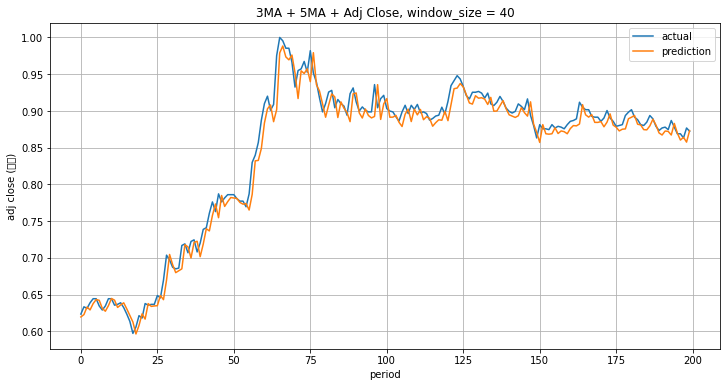

In [18]:
pred = model.predict(x_test)

plt.figure(figsize = (12,6))
plt.title('3MA + 5MA + Adj Close, window_size = 40')
plt.ylabel('adj close (종가)')
plt.xlabel('period')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()